## Gated GCN tutorial
As seen on: https://github.com/Atcold/pytorch-Deep-Learning/blob/master/16-gated_GCN.ipynb

This tutorial uses [Deep Graph Library](https://www.dgl.ai/) which is similar framework to [PyTorch-Geometric](https://pytorch-geometric.readthedocs.io/en/latest/) to apply Graph based learning in PyTorch 

In [15]:
import os 
import time
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [16]:
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader 

In [17]:
os.environ['DGLBACKEND'] = 'pytorch'  # tell DGL what backend to use
import dgl
from dgl import DGLGraph
from dgl.data import MiniGCDataset

In [18]:
def draw(g, title):
    plt.figure()
    nx.draw(g.to_networkx(), with_labels=True, node_color='skyblue', edge_color='k')
    plt.title(title)

In [19]:
# The datset contains 8 different types of graphs:
graph_type = (
    'cycle',
    'star',
    'wheel',
    'lollipop',
    'hypercube',
    'grid',
    'clique',
    'circular ladder',
)

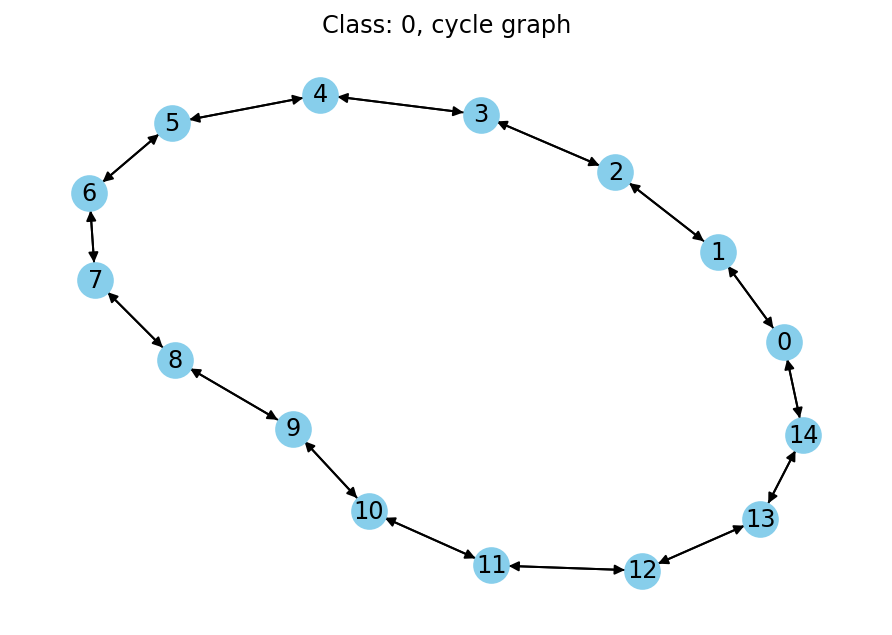

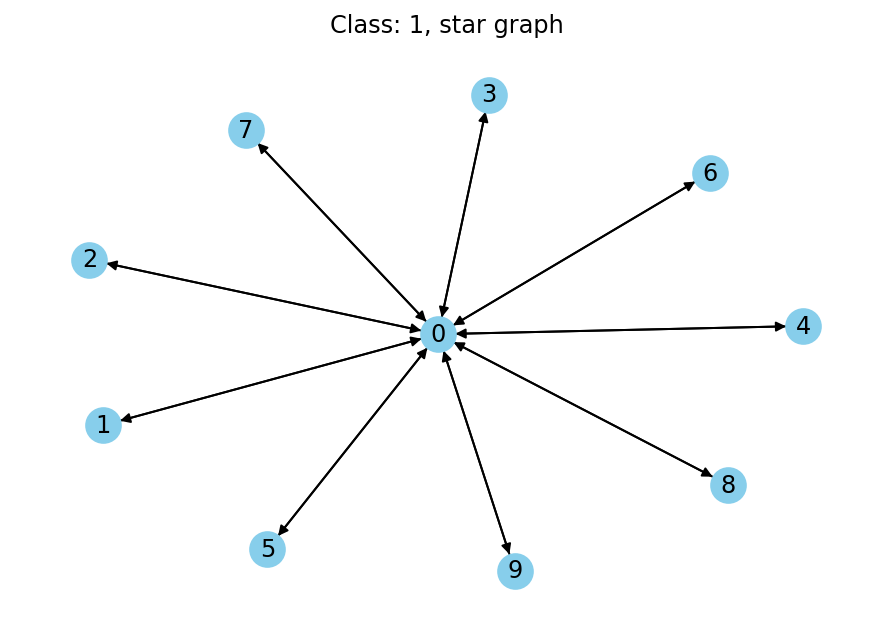

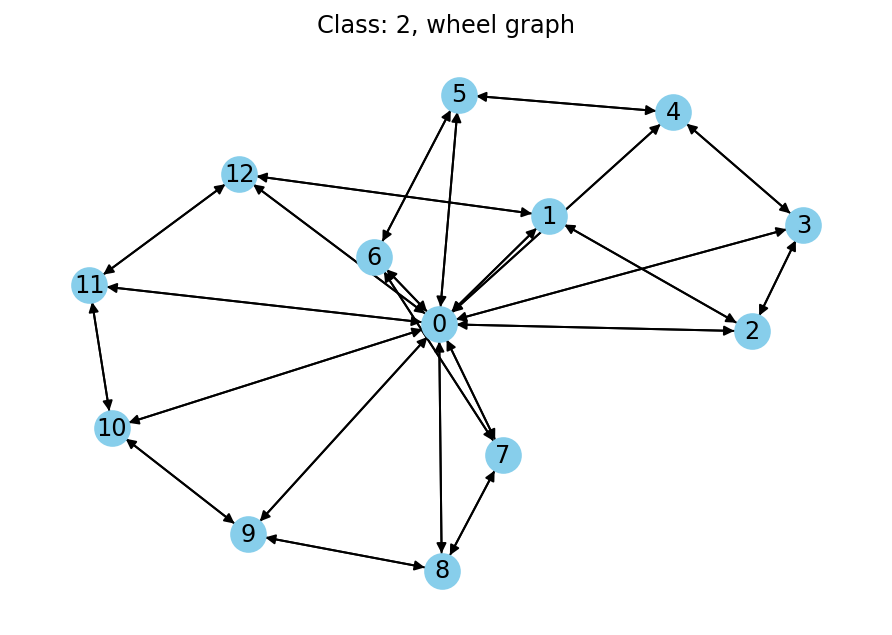

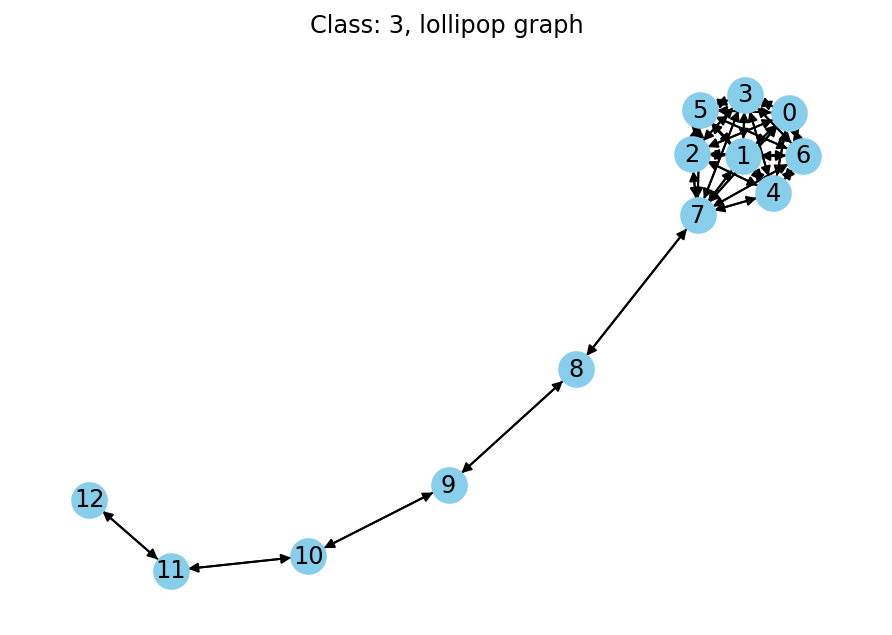

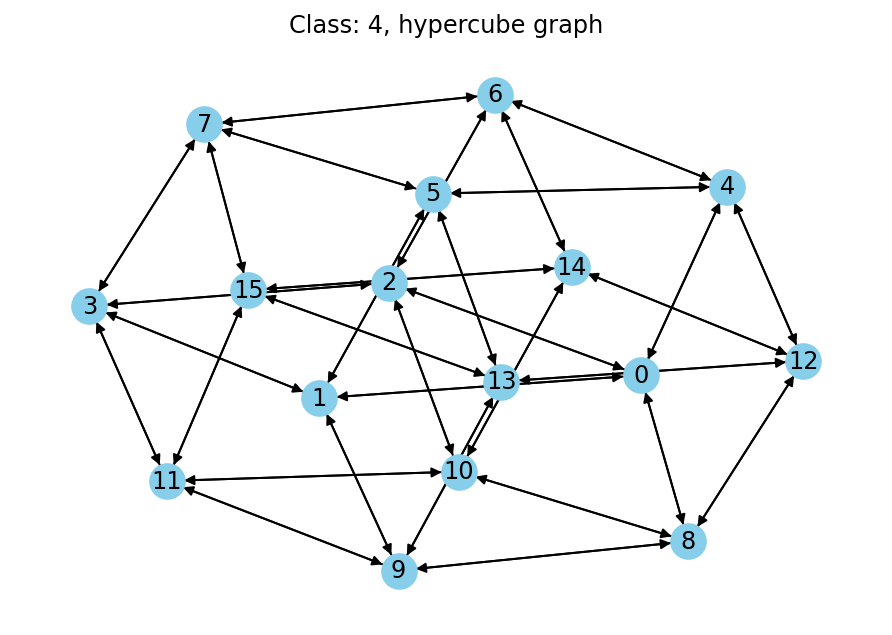

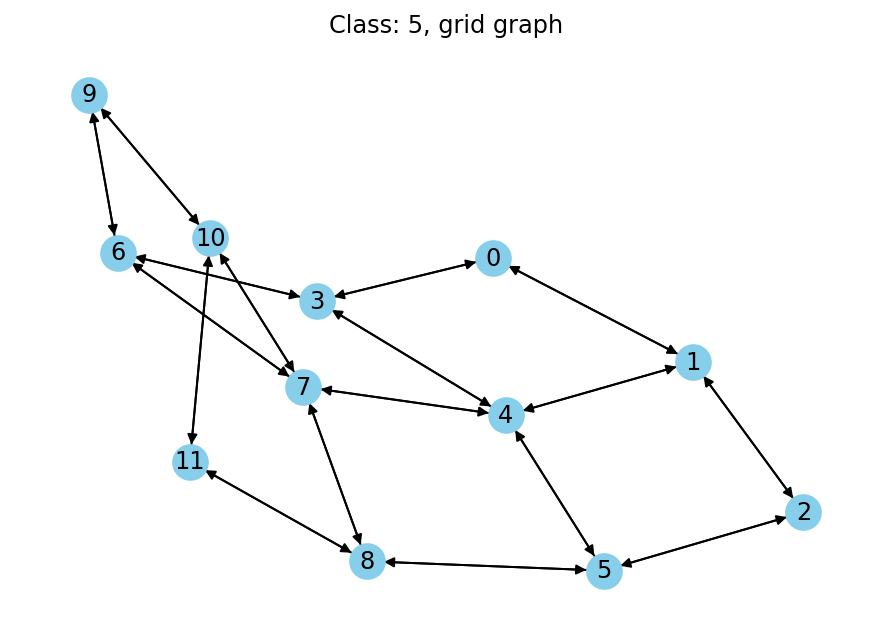

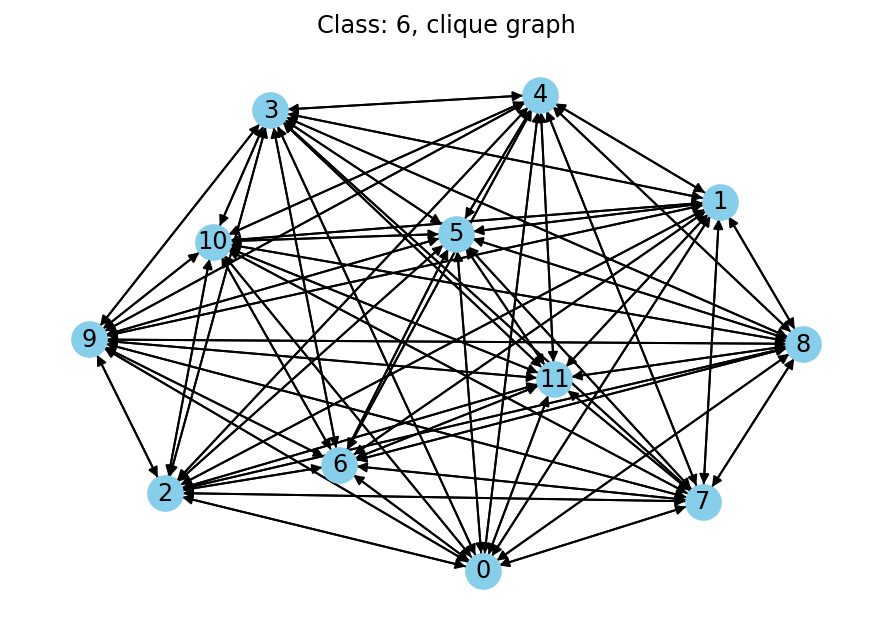

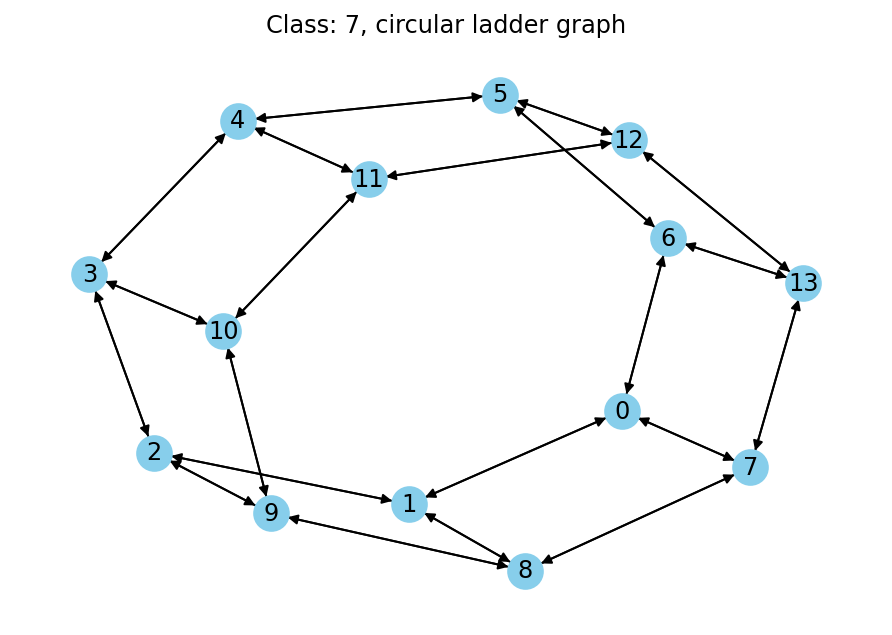

In [20]:
# visualise the 8 classes of graphs
for graph, label in MiniGCDataset(8, 10, 20):
    draw(graph, f'Class: {label}, {graph_type[label]} graph')

### ### Adding features to the graphs 

In [21]:
# create artifical data feature (= in degree) for each node
def create_artificial_features(dataset):
    for (graph, _) in dataset:
        graph.ndata['feat'] = graph.in_degrees().view(-1, 1).float()
        graph.edata['feat'] = torch.ones(graph.number_of_edges(), 1)
    return dataset

In [22]:
# Generate artifical graph dataset with DGL
trainset = MiniGCDataset(350, 10, 20)
testset = MiniGCDataset(100, 10, 20)

trainset = create_artificial_features(trainset)
testset = create_artificial_features(testset)

print(trainset[0])

(Graph(num_nodes=15, num_edges=45,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}), tensor(0))


In [23]:
class GatedGCN_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.A = nn.Linear(input_dim, output_dim)
        self.B = nn.Linear(input_dim, output_dim)
        self.C = nn.Linear(input_dim, output_dim)
        self.D = nn.Linear(input_dim, output_dim)
        self.E = nn.Linear(input_dim, output_dim)
        self.bn_node_h = nn.BatchNorm1d(output_dim)
        self.bn_node_e = nn.BatchNorm1d(output_dim)

    def message_func(self, edges):
        Bh_j = edges.src['Bh']
        # e_ij = Ce_ij + Dhi + Ehj
        e_ij = edges.data['Ce'] + edges.src['Dh'] + edges.dst['Eh']
        edges.data['e'] = e_ij
        return {'Bh_j' : Bh_j, 'e_ij' : e_ij}

    def reduce_func(self, nodes):
        Ah_i = nodes.data['Ah']
        Bh_j = nodes.mailbox['Bh_j']
        e = nodes.mailbox['e_ij']
        # sigma_ij = sigmoid(e_ij)
        sigma_ij = torch.sigmoid(e)
        # hi = Ahi + sum_j eta_ij * Bhj
        h = Ah_i + torch.sum(sigma_ij * Bh_j, dim=1) / torch.sum(sigma_ij, dim=1)
        return {'h' : h}
    
    def forward(self, g, h, e, snorm_n, snorm_e):
        
        h_in = h # residual connection
        e_in = e # residual connection
        
        g.ndata['h']  = h 
        g.ndata['Ah'] = self.A(h) 
        g.ndata['Bh'] = self.B(h) 
        g.ndata['Dh'] = self.D(h)
        g.ndata['Eh'] = self.E(h) 
        g.edata['e']  = e 
        g.edata['Ce'] = self.C(e)
        
        g.update_all(self.message_func, self.reduce_func)
        
        h = g.ndata['h'] # result of graph convolution
        e = g.edata['e'] # result of graph convolution
        
        h = h * snorm_n # normalize activation w.r.t. graph node size
        e = e * snorm_e # normalize activation w.r.t. graph edge size
        
        h = self.bn_node_h(h) # batch normalization  
        e = self.bn_node_e(e) # batch normalization  
        
        h = torch.relu(h) # non-linear activation
        e = torch.relu(e) # non-linear activation
        
        h = h_in + h # residual connection
        e = e_in + e # residual connection
        
        return h, e

In [24]:
class MLP_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim, L=2): # L = nb of hidden layers
        super().__init__()
        list_FC_layers = [
            nn.Linear(input_dim, input_dim) for l in range(L)
        ]
        list_FC_layers.append(nn.Linear(input_dim, output_dim))
        self.FC_layers = nn.ModuleList(list_FC_layers)
        self.L = L
        
    def forward(self, x):
        y = x
        for l in range(self.L):
            y = self.FC_layers[l](y)
            y = torch.relu(y)
        y = self.FC_layers[self.L](y)
        return y

In [25]:
class GatedGCN(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, L):
        super().__init__()
        self.embedding_h = nn.Linear(input_dim, hidden_dim)
        self.embedding_e = nn.Linear(1, hidden_dim)
        self.GatedGCN_layers = nn.ModuleList([
            GatedGCN_layer(hidden_dim, hidden_dim) for _ in range(L)
        ])
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)
        
    def forward(self, g, h, e, snorm_n, snorm_e):
        
        # input embedding
        h = self.embedding_h(h)
        e = self.embedding_e(e)
        
        # graph convnet layers
        for GGCN_layer in self.GatedGCN_layers:
            h, e = GGCN_layer(g, h, e, snorm_n, snorm_e)
        
        # MLP classifier
        g.ndata['h'] = h
        y = dgl.mean_nodes(g,'h')
        y = self.MLP_layer(y)
        
        return y

`dgl.mean_nodes()` function averages the outputs for all the nodes in a given graph over a defined feature. In this case, the attribute meaned over is `h`  

In [26]:
# instantiate network
model = GatedGCN(input_dim=1, hidden_dim=100, output_dim=8, L=2)
print(model)

GatedGCN(
  (embedding_h): Linear(in_features=1, out_features=100, bias=True)
  (embedding_e): Linear(in_features=1, out_features=100, bias=True)
  (GatedGCN_layers): ModuleList(
    (0): GatedGCN_layer(
      (A): Linear(in_features=100, out_features=100, bias=True)
      (B): Linear(in_features=100, out_features=100, bias=True)
      (C): Linear(in_features=100, out_features=100, bias=True)
      (D): Linear(in_features=100, out_features=100, bias=True)
      (E): Linear(in_features=100, out_features=100, bias=True)
      (bn_node_h): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_node_e): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): GatedGCN_layer(
      (A): Linear(in_features=100, out_features=100, bias=True)
      (B): Linear(in_features=100, out_features=100, bias=True)
      (C): Linear(in_features=100, out_features=100, bias=True)
      (D): Linear(in_features=100, out_features=100, 

In [27]:
# Collate function to prepare graphs
def collate(samples):
    graphs, labels = map(list, zip(*samples))  # samples is a list of pairs (graph, label)
    labels = torch.tensor(labels)
    sizes_n = [graph.number_of_nodes() for graph in graphs] # graph sizes
    snorm_n = [torch.FloatTensor(size, 1).fill_(1 / size) for size in sizes_n]
    snorm_n = torch.cat(snorm_n).sqrt()  # graph size normalization 
    sizes_e = [graph.number_of_edges() for graph in graphs] # nb of edges
    snorm_e = [torch.FloatTensor(size, 1).fill_(1 / size) for size in sizes_e]
    snorm_e = torch.cat(snorm_e).sqrt()  # graph size normalization
    batched_graph = dgl.batch(graphs)  # batch graphs
    return batched_graph, labels, snorm_n, snorm_e

In [28]:
# Compute accuracy

def accuracy(logits, targets):
    preds = logits.detach().argmax(dim=1)
    acc = (preds==targets).sum().item()
    return acc

## ## Test forward pass

In [29]:
# Define DataLoader and get first graph batch
train_loader = DataLoader(trainset, batch_size=10, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e = next(iter(train_loader))
batch_x = batch_graphs.ndata['feat']
batch_e = batch_graphs.edata['feat']

In [30]:
# Checking some sizes
print(f'batch_graphs:', batch_graphs)
print(f'batch_labels:', batch_labels)
print('batch_x size:', batch_x.size())
print('batch_e size:', batch_e.size())

batch_graphs: Graph(num_nodes=122, num_edges=716,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)})
batch_labels: tensor([5, 6, 1, 3, 4, 7, 4, 2, 4, 4])
batch_x size: torch.Size([122, 1])
batch_e size: torch.Size([716, 1])


In [31]:
batch_scores = model(batch_graphs, batch_x, batch_e, batch_snorm_n, batch_snorm_e)
print(batch_scores.size())

batch_labels = batch_labels
print(f'accuracy: {accuracy(batch_scores, batch_labels)}')

torch.Size([10, 8])
accuracy: 1


## ## Test backward pass

In [32]:
# Loss
J = nn.CrossEntropyLoss()(batch_scores, batch_labels)

# Backward pass
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer.zero_grad()
J.backward()
optimizer.step()

## Train

In [33]:
def train(model, data_loader, loss):

    model.train()
    epoch_loss = 0
    epoch_train_acc = 0
    nb_data = 0
    gpu_mem = 0

    for iter, (batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e) in enumerate(data_loader):
        batch_x = batch_graphs.ndata['feat']
        batch_e = batch_graphs.edata['feat']
        
        batch_scores = model(batch_graphs, batch_x, batch_e, batch_snorm_n, batch_snorm_e)
        J = loss(batch_scores, batch_labels)
        optimizer.zero_grad()
        J.backward()
        optimizer.step()
        
        epoch_loss += J.detach().item()
        epoch_train_acc += accuracy(batch_scores, batch_labels)
        nb_data += batch_labels.size(0)

    epoch_loss /= (iter + 1)
    epoch_train_acc /= nb_data

    return epoch_loss, epoch_train_acc

## Evaluation

In [34]:
def evaluate(model, data_loader, loss):

    model.eval()
    epoch_test_loss = 0
    epoch_test_acc = 0
    nb_data = 0
    
    with torch.no_grad():
        for iter, (batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e) in enumerate(data_loader):
            batch_x = batch_graphs.ndata['feat']
            batch_e = batch_graphs.edata['feat']

            batch_scores = model(batch_graphs, batch_x, batch_e, batch_snorm_n, batch_snorm_e)
            J = loss(batch_scores, batch_labels)

            epoch_test_loss += J.detach().item()
            epoch_test_acc += accuracy(batch_scores, batch_labels)
            nb_data += batch_labels.size(0)

        epoch_test_loss /= (iter + 1)
        epoch_test_acc /= nb_data
    
    return epoch_test_loss, epoch_test_acc

# Train GCN

In [35]:
# datasets
train_loader = DataLoader(trainset, batch_size=50, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=50, shuffle=False, collate_fn=collate)

# Create model
model = GatedGCN(input_dim=1, hidden_dim=100, output_dim=8, L=4)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epoch_train_losses = []
epoch_test_losses = []
epoch_train_accs = []
epoch_test_accs = []

for epoch in range(40):
    
    start = time.time()
    train_loss, train_acc = train(model, train_loader, loss)
    test_loss, test_acc = evaluate(model, test_loader, loss)
        
    print(f'Epoch {epoch}, train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}')
    print(f'train_acc: {train_acc:.4f}, test_acc: {test_acc:.4f}')

Epoch 0, train_loss: 2.0401, test_loss: 2.0292
train_acc: 0.1829, test_acc: 0.2300
Epoch 1, train_loss: 1.8785, test_loss: 1.9418
train_acc: 0.4029, test_acc: 0.3600
Epoch 2, train_loss: 1.7754, test_loss: 1.8608
train_acc: 0.3800, test_acc: 0.3600
Epoch 3, train_loss: 1.7123, test_loss: 1.7804
train_acc: 0.3686, test_acc: 0.3600
Epoch 4, train_loss: 1.6310, test_loss: 1.6936
train_acc: 0.4286, test_acc: 0.3700
Epoch 5, train_loss: 1.5669, test_loss: 1.6090
train_acc: 0.5057, test_acc: 0.4200
Epoch 6, train_loss: 1.5360, test_loss: 1.5317
train_acc: 0.5457, test_acc: 0.5200
Epoch 7, train_loss: 1.4425, test_loss: 1.4590
train_acc: 0.6171, test_acc: 0.5200
Epoch 8, train_loss: 1.3883, test_loss: 1.3945
train_acc: 0.6829, test_acc: 0.6200
Epoch 9, train_loss: 1.3276, test_loss: 1.3325
train_acc: 0.6943, test_acc: 0.6500
Epoch 10, train_loss: 1.2797, test_loss: 1.2713
train_acc: 0.6971, test_acc: 0.6500
Epoch 11, train_loss: 1.2575, test_loss: 1.2277
train_acc: 0.6857, test_acc: 0.6700
Ep